<a href="https://colab.research.google.com/github/vu-topics-in-big-data-2021/examples/blob/main/spark-ml/ml_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://spark.apache.org/docs/3.1.1/ml-pipeline.html

In [1]:
#ML Pipelines provide a uniform set of high-level APIs built on top of DataFrames that help users create and tune practical machine learning pipelines with spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#install spark. we are using the one that uses hadoop as the underlying scheduler.
!wget -q https://downloads.apache.org/spark//spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!ls -l
os.environ["SPARK_HOME"] = "spark-3.1.1-bin-hadoop3.2"
!pip install -q findspark
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Learning_Spark") \
    .getOrCreate()

total 223372
drwxr-xr-x  1 root root      4096 Apr 21 13:39 sample_data
drwxr-xr-x 13 1000 1000      4096 Feb 22 02:11 spark-3.1.1-bin-hadoop3.2
-rw-r--r--  1 root root 228721937 Feb 22 02:45 spark-3.1.1-bin-hadoop3.2.tgz


MLlib standardizes APIs for machine learning algorithms to make it easier to combine multiple algorithms into a single pipeline, or workflow. This section covers the key concepts introduced by the Pipelines API, where the pipeline concept is mostly inspired by the scikit-learn project.

* DataFrame: This ML API uses DataFrame from Spark SQL as an ML dataset, which can hold a variety of data types. E.g., a DataFrame could have different columns storing text, feature vectors, true labels, and predictions.

* Transformer: A Transformer is an algorithm which can transform one DataFrame into another DataFrame. E.g., an ML model is a Transformer which transforms a DataFrame with features into a DataFrame with predictions.

* Estimator: An Estimator is an algorithm which can be fit on a DataFrame to produce a Transformer. E.g., a learning algorithm is an Estimator which trains on a DataFrame and produces a model.

* Pipeline: A Pipeline chains multiple Transformers and Estimators together to specify an ML workflow.

* Parameter: All Transformers and Estimators now share a common API for specifying parameters.

 



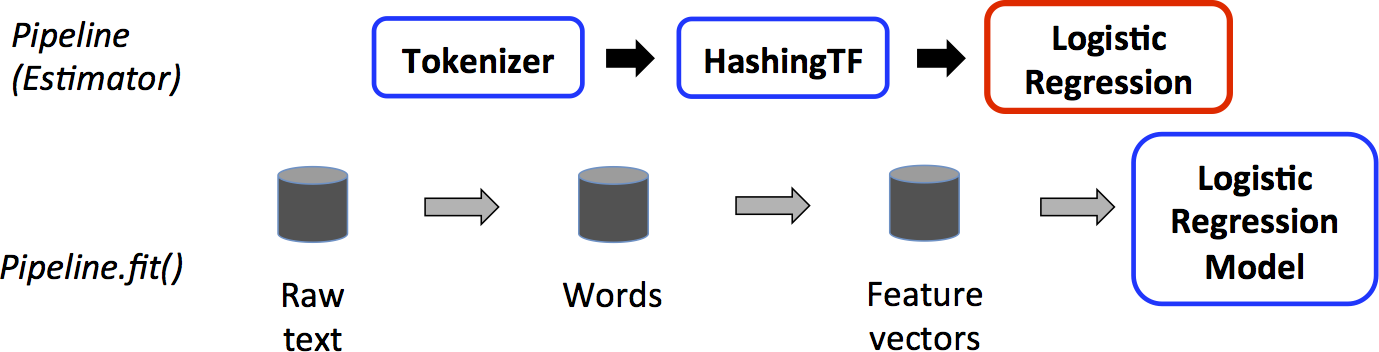

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer

# Prepare training documents from a list of (id, text, label) tuples.
training = spark.createDataFrame([
    (0, "a b c d e spark", 1.0),
    (1, "b d", 0.0),
    (2, "spark f g h", 1.0),
    (3, "hadoop mapreduce", 0.0)
], ["id", "text", "label"])

# Configure an ML pipeline, which consists of three stages: tokenizer, hashingTF, and lr.
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.001)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# Fit the pipeline to training documents.
model = pipeline.fit(training)

# Prepare test documents, which are unlabeled (id, text) tuples.
test = spark.createDataFrame([
    (4, "spark i j k"),
    (5, "l m n"),
    (6, "spark hadoop spark"),
    (7, "apache hadoop")
], ["id", "text"])

# Make predictions on test documents and print columns of interest.
prediction = model.transform(test)
selected = prediction.select("id", "text", "probability", "prediction")
for row in selected.collect():
    rid, text, prob, prediction = row  # type: ignore
    print(
        "(%d, %s) --> prob=%s, prediction=%f" % (
            rid, text, str(prob), prediction   # type: ignore
        )
    )

(4, spark i j k) --> prob=[0.1596407738787412,0.8403592261212588], prediction=1.000000
(5, l m n) --> prob=[0.8378325685476614,0.16216743145233858], prediction=0.000000
(6, spark hadoop spark) --> prob=[0.06926633132976266,0.9307336686702373], prediction=1.000000
(7, apache hadoop) --> prob=[0.9821575333444208,0.017842466655579203], prediction=0.000000
